# Results analysis

#### dataset Loading and options 

In [16]:
from datasets import Dataset,load_dataset
import pandas as pd
import seaborn as sb

dataset_split = ["simpleLLM_benchmark_llama3.18binstant_t_0.7"][0]

dataset = load_dataset("CharlyR/varbench-evaluation", "tikz", split=dataset_split)


Generating simpleLLM_benchmark_llama3.18binstant_t_0.7 split: 100%|██████████| 50/50 [00:00<00:00, 4413.20 examples/s]


In [17]:
dataset

Dataset({
    features: ['id', 'code', 'instruction', 'result_description', 'difficulty', 'patch', 'code_solution', 'image_solution', 'image_input', 'predictions', 'images_result', 'parsing_score', 'compiling_score', 'predictions_patches', 'LPIPSMetric', 'FeatureMatchMetric', 'ClipImageMetric', 'ChrfPatchMetric', 'TERMetric', 'MSSSIMMetric', 'BleuPatchMetric', 'LineMetric', 'PatchMetric', 'PSNRMetric', 'ClipTextMetric', 'TERPatchMetric', 'ChrfMetric', 'BleuMetric'],
    num_rows: 50
})

## Best prediction computation

In [18]:
from results_utils import MetricPolicy


computed_metrics_names = [
    metric_name
    for metric_name in dataset.column_names
    if metric_name.endswith("Metric") and not metric_name.startswith("best")
]


# each metric is computed on list of predictions of length pass@k, and yields a list of list of result of the same length.
# from that list[list[float]](the results), we get the best result according to a certain policy(here the arithmetic mean)
subset = dataset.map(
    MetricPolicy.compute_best_prediction,
    fn_kwargs={"computed_metrics_names": computed_metrics_names},
)

scores = {
    metric_name: sum(subset[f"best_{metric_name}"]) / len(subset)
    for metric_name in computed_metrics_names
}
scores["var_score"] = sum(subset["var_score"]) / len(subset)
scores
result_df = subset.to_pandas()

Map: 100%|██████████| 50/50 [00:00<00:00, 1068.73 examples/s]


## Pre-Filtering

In [27]:
# filtering by having a result
filtered_df = result_df[result_df["index_best_prediction"] != -1]

# ordering by text metrics
text_metrics = [
    metric_name
    for metric_name in computed_metrics_names
    if any((substring in metric_name) for substring in ["TER", "Line", "Bleu", "Chrf","Patch"])
]
other_metrics = list(set(computed_metrics_names) - set(text_metrics))
ordered_metrics = text_metrics + other_metrics
filtered_df = filtered_df[ordered_metrics + ["id", "difficulty"]]
filtered_df

,ChrfPatchMetric,TERMetric,BleuPatchMetric,LineMetric,PatchMetric,TERPatchMetric,ChrfMetric,BleuMetric,ClipImageMetric,PSNRMetric,MSSSIMMetric,LPIPSMetric,FeatureMatchMetric,ClipTextMetric,id,difficulty
0,[6.1243935],[97.83282],[1.2317325],[0.0],[0.0],[51.079136],[98.82567],[97.86499],[99.85918],[45.181442],[97.17392],[99.58755],[58.44156],[22.200275],donkey_higher_mane,hard
1,[35.83078],[85.91549],[17.629316],[0.0],[0.0],[43.939392],[92.2547],[87.232475],[95.02149],[43.536983],[88.22751],[97.35404],[62.162163],[24.78446],chimpanzee_squint_crosseyes,medium
2,[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[100.0],[27.442713],bee_red_stripes,easy
3,[10.19162],[78.82736],[0.20494814],[0.0],[0.0],[51.25],[96.58736],[82.99074],[99.37684],[54.55823],[99.63105],[99.75662],[93.478264],[25.336811],shark_no_teeth,easy
4,[15.631888],[83.75635],[7.2476335],[0.0],[0.0],[51.785713],[88.86572],[87.083885],[99.55563],[48.234116],[96.84733],[97.826614],[72.58064],[26.552582],shark_other_set_pectoral_fin,hard
5,[41.100742],[92.134834],[21.569471],[0.0],[0.0],[48.57143],[98.48025],[92.41655],[96.87161],[47.829006],[94.84958],[97.82557],[58.064518],[23.243683],dog_red_eyes,easy
7,[27.98326],[98.34711],[12.423531],[0.0],[0.0],[55.844154],[99.13497],[98.72608],[99.51401],[41.423878],[87.44379],[97.0819],[38.55422],[25.911617],squid_bigger_eyes,medium
8,[37.300316],[96.174866],[18.596203],[0.0],[0.0],[47.115383],[96.893456],[97.14141],[93.24947],[35.607243],[82.16467],[95.38803],[40.0],[28.118896],chimpanzee_blue_fur,easy
9,[63.498074],[94.495415],[58.1283],[0.0],[0.0],[65.15151],[97.752525],[97.169106],[99.36806],[44.33442],[97.8831],[99.59982],[76.74419],[25.674559],cow_longer_horns,medium
11,[24.527388],[93.965515],[9.3839655],[50.0],[0.0],[53.52941],[97.63793],[95.57393],[95.7173],[35.269596],[57.1959],[93.31837],[35.555557],[26.930805],cat_big,medium


In [28]:
from results_utils import flatten_metrics
#flattening the pass arrays
flatten_df = flatten_metrics(filtered_df,ordered_metrics)

In [29]:
flatten_df

,ChrfPatchMetric,TERMetric,BleuPatchMetric,LineMetric,PatchMetric,TERPatchMetric,ChrfMetric,BleuMetric,ClipImageMetric,PSNRMetric,MSSSIMMetric,LPIPSMetric,FeatureMatchMetric,ClipTextMetric,difficulty,id
0,6.124393,97.832817,1.231732,0.0,0.0,51.079136,98.825668,97.864990,99.859177,45.181442,97.173920,99.587547,58.441559,22.200275,hard,donkey_higher_mane
1,35.830780,85.915489,17.629316,0.0,0.0,43.939392,92.254700,87.232475,95.021492,43.536983,88.227509,97.354042,62.162163,24.784460,medium,chimpanzee_squint_crosseyes
2,100.000000,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,27.442713,easy,bee_red_stripes
3,10.191620,78.827362,0.204948,0.0,0.0,51.250000,96.587357,82.990738,99.376839,54.558231,99.631050,99.756622,93.478264,25.336811,easy,shark_no_teeth
4,15.631888,83.756348,7.247633,0.0,0.0,51.785713,88.865723,87.083885,99.555634,48.234116,96.847328,97.826614,72.580643,26.552582,hard,shark_other_set_pectoral_fin
5,41.100742,92.134834,21.569471,0.0,0.0,48.571430,98.480247,92.416550,96.871613,47.829006,94.849579,97.825569,58.064518,23.243683,easy,dog_red_eyes
6,27.983259,98.347107,12.423531,0.0,0.0,55.844154,99.134972,98.726082,99.514008,41.423878,87.443787,97.081902,38.554218,25.911617,medium,squid_bigger_eyes
7,37.300316,96.174866,18.596203,0.0,0.0,47.115383,96.893456,97.141411,93.249474,35.607243,82.164673,95.388031,40.000000,28.118896,easy,chimpanzee_blue_fur
8,63.498074,94.495415,58.128300,0.0,0.0,65.151512,97.752525,97.169106,99.368057,44.334419,97.883102,99.599823,76.744186,25.674559,medium,cow_longer_horns
9,24.527388,93.965515,9.383965,50.0,0.0,53.529411,97.637932,95.573929,95.717300,35.269596,57.195900,93.318367,35.555557,26.930805,medium,cat_big


## no subcategories

<Axes: >

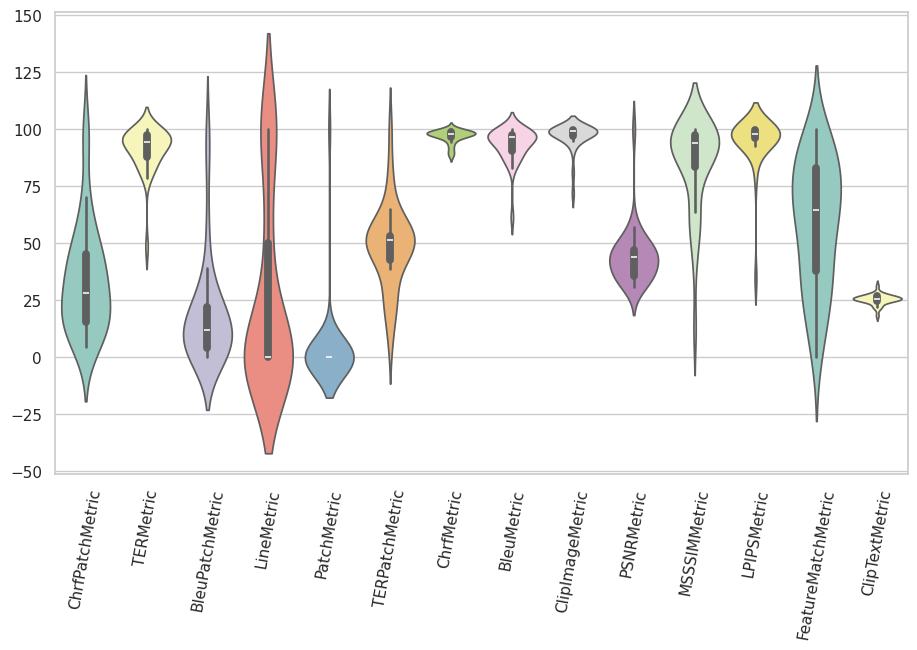

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=80)

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=flatten_df, palette="Set3")


In [37]:
flatten_df[flatten_df.columns.difference(['difficulty','id'])].mean(axis=0)

BleuMetric            93.325562
BleuPatchMetric       18.819973
ChrfMetric            96.933105
ChrfPatchMetric       34.095741
ClipImageMetric       97.023346
ClipTextMetric        25.435474
FeatureMatchMetric    58.669472
LPIPSMetric           94.801605
LineMetric            26.562500
MSSSIMMetric          84.444839
PSNRMetric            44.249863
PatchMetric            3.125000
TERMetric             91.212173
TERPatchMetric        48.713364
dtype: float32

<Axes: >

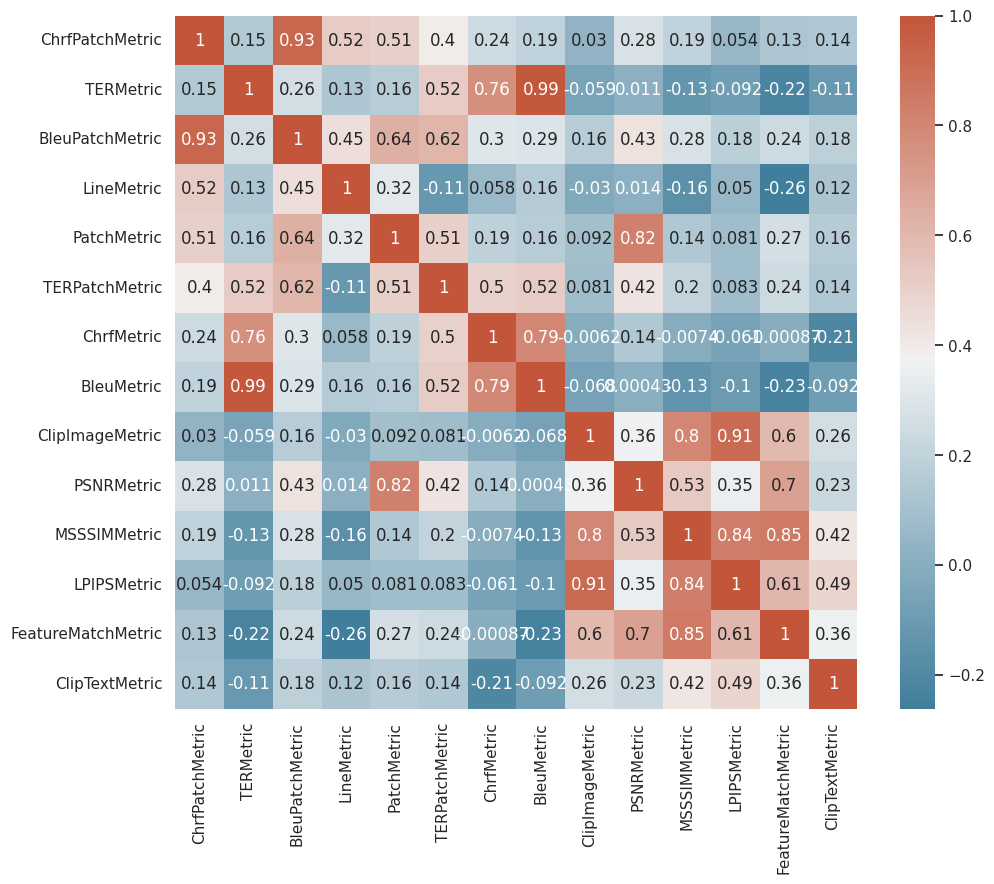

In [31]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = flatten_df.select_dtypes(["int","float"]).corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, annot=True)

## filtered by difficulty

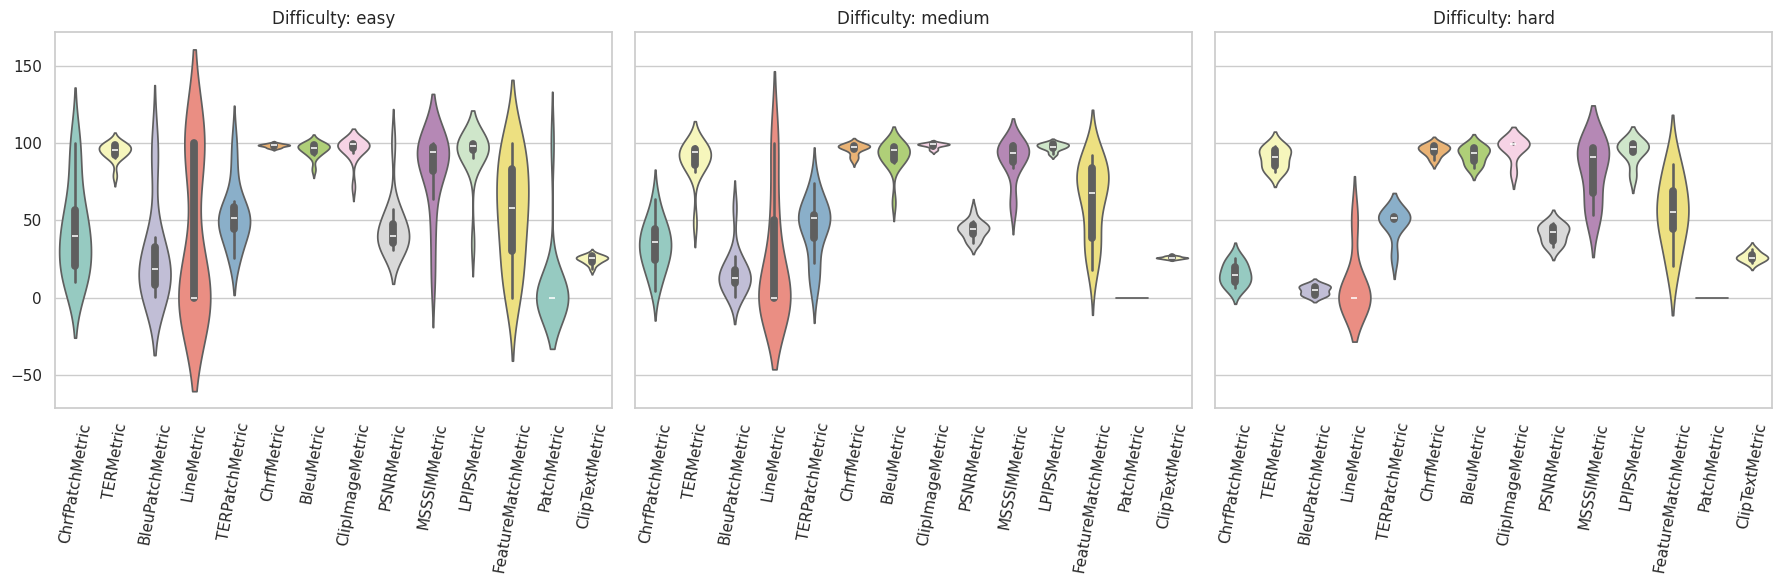

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

df_difficulty = flatten_df.drop("id",axis=1)
df_difficulty

sns.set_theme(style="whitegrid")

# Assuming 'difficulty' column exists in the DataFrame
difficulties = ['easy', 'medium', 'hard']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Create 3 subplots

for i, difficulty in enumerate(difficulties):
    sns.violinplot(
        data=df_difficulty[df_difficulty['difficulty'] == difficulty], 
        ax=axes[i], 
        palette="Set3"
    )
    axes[i].set_title(f'Difficulty: {difficulty}')
    axes[i].tick_params(axis='x', rotation=80)

plt.tight_layout()
plt.show()


In [25]:
df_difficulty['difficulty'] = pd.Categorical(df_difficulty['difficulty'], categories=['easy', 'medium', 'hard'], ordered=True)
averages = df_difficulty.groupby('difficulty',observed=True).mean()
averages

,ChrfPatchMetric,TERMetric,BleuPatchMetric,LineMetric,TERPatchMetric,ChrfMetric,BleuMetric,ClipImageMetric,PSNRMetric,MSSSIMMetric,LPIPSMetric,FeatureMatchMetric,PatchMetric,ClipTextMetric
difficulty,,,,,,,,,,,,,,
easy,43.465603,94.519211,27.865501,38.461540,53.087811,98.402107,95.797966,95.885948,45.901157,81.325592,92.179939,55.618263,7.692307,24.622536
medium,33.469643,88.367073,16.310257,23.076923,44.827324,96.212021,91.348503,98.429779,43.995136,88.791618,97.571426,63.256260,0.000000,25.827127
hard,15.150899,90.211334,4.659033,8.333333,47.655163,95.312653,92.252327,96.440422,41.223980,81.785194,94.480591,55.342381,0.000000,26.348265


In [26]:
med = df_difficulty.groupby('difficulty',observed=True).median()
med

,ChrfPatchMetric,TERMetric,BleuPatchMetric,LineMetric,TERPatchMetric,ChrfMetric,BleuMetric,ClipImageMetric,PSNRMetric,MSSSIMMetric,LPIPSMetric,FeatureMatchMetric,PatchMetric,ClipTextMetric
difficulty,,,,,,,,,,,,,,
easy,40.080460,95.757576,18.596203,0.0,51.250000,98.591225,97.084702,99.264832,39.844341,93.997589,97.825569,58.064518,0.0,25.336811
medium,35.734150,93.965515,12.423531,0.0,51.388889,97.637932,95.573929,99.084465,44.334419,93.516449,97.587921,67.567566,0.0,25.674559
hard,14.615059,91.180305,5.040946,0.0,51.432426,96.134644,93.724854,99.546127,42.685886,90.685020,97.631889,55.262444,0.0,25.860937
